Summarize Text

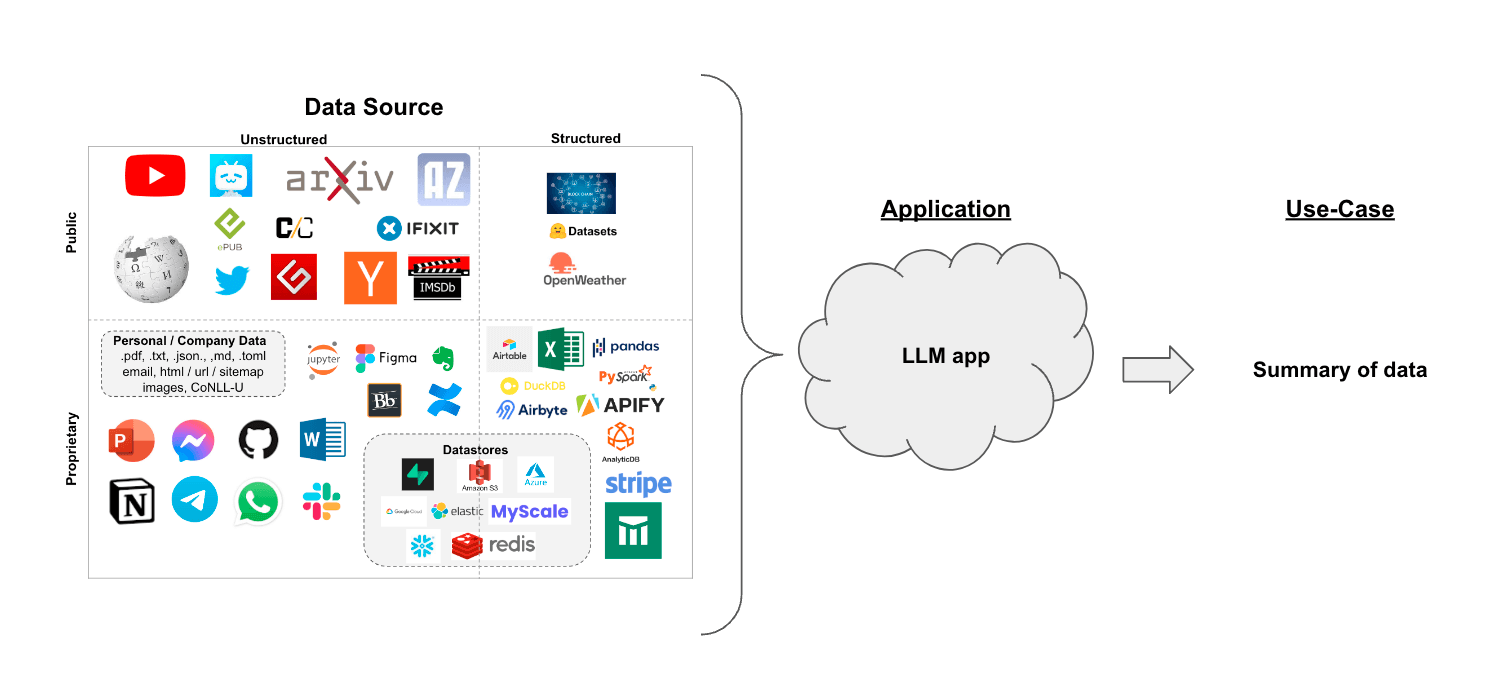

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
import getpass
import os
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.environ['groqe_api_key']
model = ChatGroq(model="llama3-8b-8192")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.environ["langchain_api_key"]


In [2]:
from langchain.embeddings import HuggingFaceEmbeddings
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20376\2566399143.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf = HuggingFaceEmbeddings(
d:\a27_YEARS_OLD\ml_tools\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


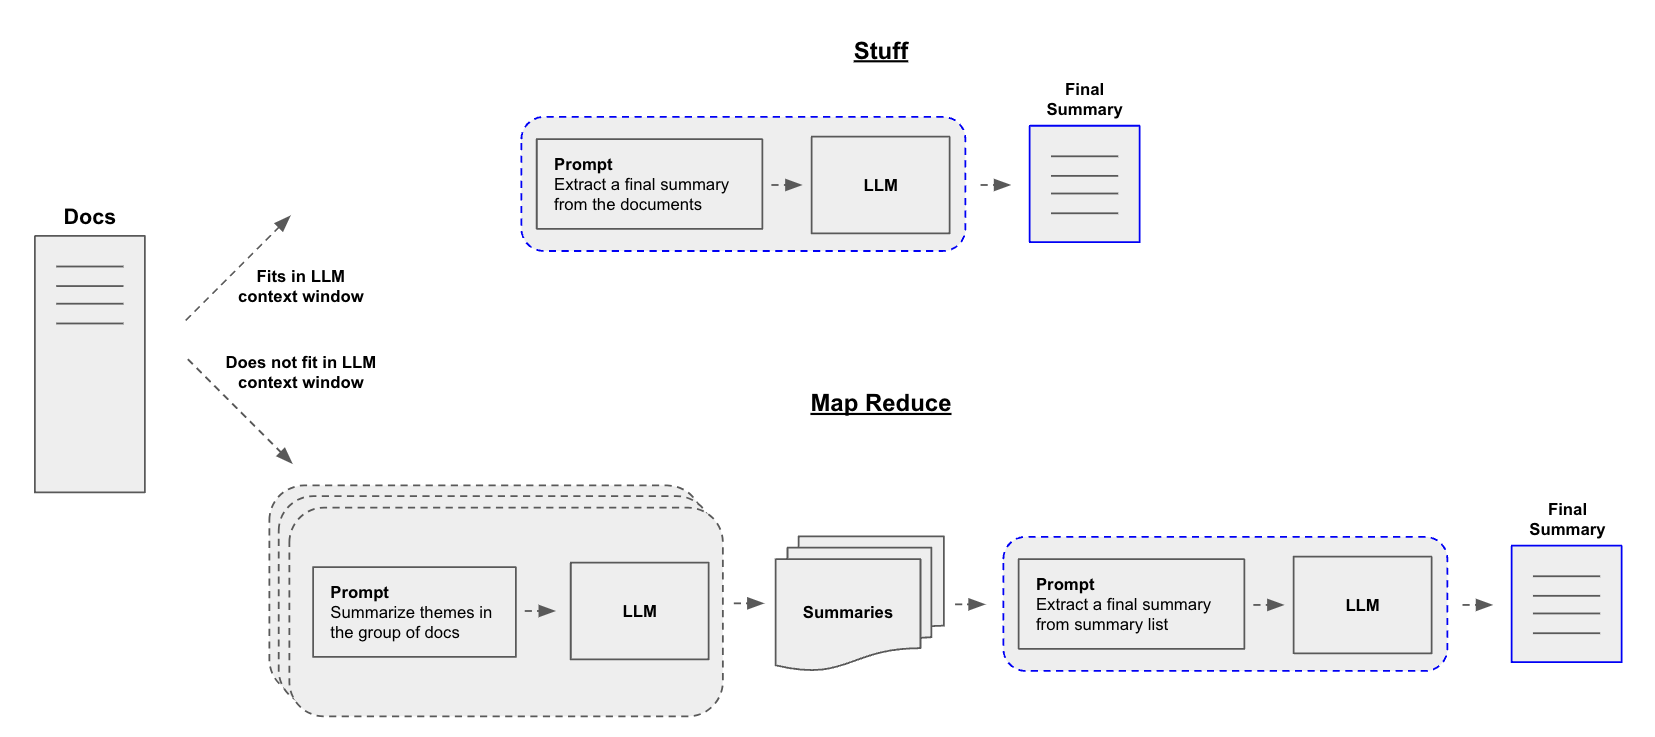

In [4]:

# Set the USER_AGENT environment variable
os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'

In [5]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [7]:
from langchain_community.document_loaders import PyPDFLoader

In [8]:
file_path = "../PINN/pinn.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()

In [9]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(model, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

Physics-informed neural networks (PINNs) are a type of neural network that incorporates physical laws described by differential equations into their loss functions to guide the learning process towards solutions that are more consistent with the underlying physics. PINNs can be used to:

* Approximate solutions to partial differential equations (PDEs) and ordinary differential equations (ODEs)
* Solve inverse problems, such as estimating model parameters from limited data
* Make more accurate predictions outside of the training data set
* Generalize well with limited or noisy training data
* Solve high-dimensional PDEs
* Enable fast "online" prediction

PINNs differ from traditional neural networks in their ability to incorporate a priori domain knowledge of the problem in the form of differential equations. This additional information enables PINNs to make more accurate predictions outside of the given measurement data.

The benefits of PINNs include:

* More accurate predictions outs

In [10]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|Here| is| a| concise| summary| of| the| article|:

|Physics|-In|formed| Neural| Networks| (|PIN|Ns|)| are| a| type| of| neural| network| that| incorporates| physical| laws| described| by| differential| equations| into| their| loss| functions| to| guide| the| learning| process| towards| solutions| that| are| more| consistent| with| the| underlying| physics|.| PIN|Ns| can| be| used| to|:

|*| Approx|imate| solutions| to| partial| differential| equations| (|P|DE|s|)| and| ordinary| differential| equations| (|ODE|s|)
|*| Solve| inverse| problems|,| such| as| estimating| model| parameters| from| limited| data|
|*| Int|egrate| with| MATLAB| and| Sim|ul|ink| for| system|-level| simulation|,| control| design|,| and| design| optimization|

|PIN|Ns| have| several| benefits| compared| to| purely| data|-driven| approaches| and| traditional| numerical| methods|,| including|:

|*| More| accurate| predictions| outside| of| the| training| data| set|
|*| Ability| to| solve| high|-dimensional| P|DE|s| 

Map-Reduce: summarize long texts via parallelization

Concepts we will cover are:

Using language models.

Using document loaders, specifically the WebBaseLoader to load content from an HTML webpage.

Two ways to summarize or otherwise combine documents.

Stuff, which simply concatenates documents into a prompt;
Map-reduce, for larger sets of documents. This splits documents into batches, summarizes those, and then summarizes the summaries.

Map

In [11]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

In [12]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")

Reduce

In [13]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

Orchestration via LangGraph

In [15]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 8 documents.


In [16]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(model.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await model.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await model.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

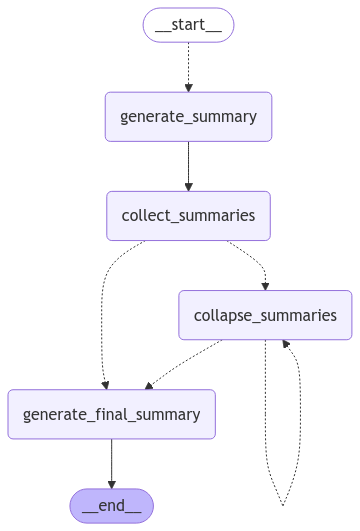

In [17]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [18]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [29]:
print(step)

{'generate_final_summary': {'final_summary': 'Here is a consolidated summary of the main themes:\n\nThe main themes that emerge from the documents are the application of deep learning and machine learning techniques to solve complex mathematical problems, particularly in the context of Physics-Informed Neural Networks (PINNs). The themes include:\n\n* **Physics-Informed Neural Networks (PINNs)**: Combining neural networks with physical laws and constraints to solve problems in various fields, such as partial differential equations (PDEs).\n* **Advantages**: PINNs differ from traditional neural networks and purely data-driven approaches by incorporating domain knowledge and physical laws to make more accurate predictions, and can regularize the predicted solution in the presence of noisy measurement data.\n* **Applications**: PINNs are applied to solve PDEs, a key area of research in fields such as physics, engineering, and computer science, and have been applied to various fields inclu

Asyncio is a library in Python that allows you to write single-threaded, concurrent code using coroutines, multiplexing I/O access over sockets and other resources, and implementing network clients and servers.
Key Concepts:
Coroutines: Special types of functions that can suspend and resume their execution at specific points, allowing other coroutines to run in the meantime.
Event Loop: The core of every asyncio application, responsible for managing the execution of coroutines and handling I/O operations.
Futures: Represent the result of an asynchronous operation, allowing you to wait for its completion and retrieve the result.

asyncio.run(): Starts the asyncio event loop and runs the given coroutine.
asyncio.sleep(): Suspends the execution of the current coroutine for the given amount of time.
asyncio.gather(): Runs multiple coroutines concurrently and returns their results.
asyncio.create_task(): Creates a task that runs the given coroutine.


Web development: Use asyncio to handle multiple requests concurrently and improve the performance of your web application.
Networking: Use asyncio to handle multiple network connections concurrently and improve the performance of your network application.
Data processing: Use asyncio to process large datasets concurrently and improve the performance of your data processing application.

In [ ]:
import asyncio

async def my_coroutine():
    print("Starting coroutine")
    await asyncio.sleep(1)  # Simulate I/O-bound operation  Pause execution for 1 second
    print("Coroutine finished")

async def main():
    print("Starting main")
    await my_coroutine()
    print("Main finished")



In [22]:
main()

<coroutine object main at 0x0000025C84A7E440>

In [ ]:
asyncio.create_task(main())

<Task pending name='Task-167' coro=<main() running at C:\Users\lenovo\AppData\Local\Temp\ipykernel_20376\830628454.py:8>>

Starting main
Starting coroutine
Coroutine finished
Main finished


In [26]:
import time


In [27]:
def my_coroutine():
    print("Starting coroutine")
    time.sleep(10)   # Simulate I/O-bound operation
    print("Coroutine finished")

def main():
    print("Starting main")
    my_coroutine()
    print("Main finished")

In [28]:
main()

Starting main
Starting coroutine
Coroutine finished
Main finished


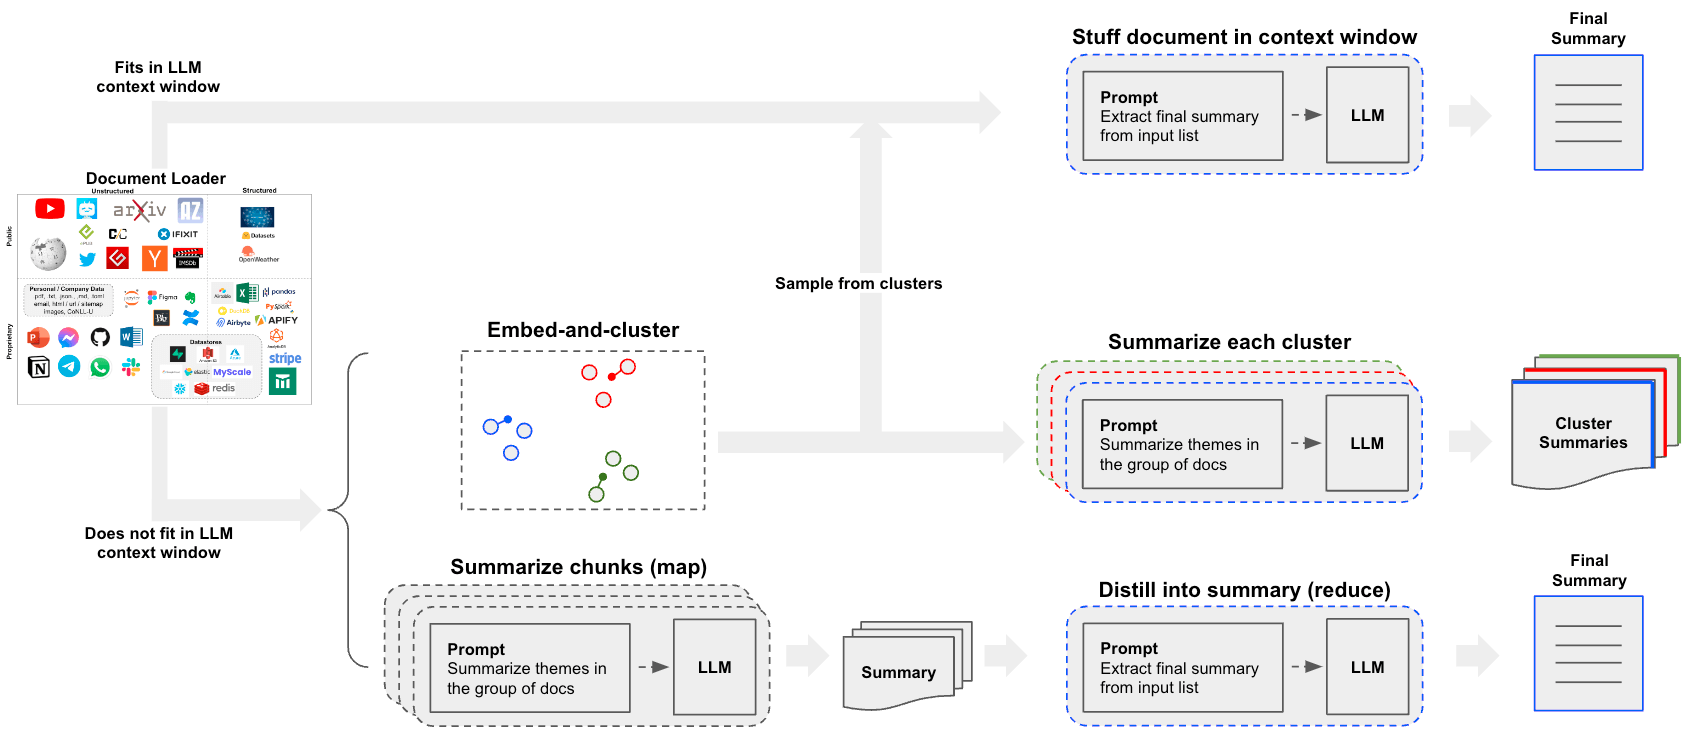